<a href="https://colab.research.google.com/github/AhmedYoussef1/Speech-Emotion-Recognition/blob/main/Speech_Emotion_Recognition_Mel_Spectogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# download the data
! wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1sL8ZzGo56zE05IEeOW3qFTUSs8EOzb0A' -O "kaggle.json"
! mkdir ~/.kaggle
! cp ./kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en

In [ ]:
! unzip -q speech-emotion-recognition-en.zip -d /content/data # extract the data
! rm speech-emotion-recognition-en.zip # remove .zip file to save some space

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchaudio
import math, random

### Data load

In [ ]:
req_sr = 44100
labels = ['sad', 'angry', 'disgust', 'fear', 'happy', 'neutral']

In [ ]:
#@title Load from disk
from os import listdir
import librosa

imagespath = 'data/Crema/'
emotion_df = []

for wav in listdir(imagespath):
    info = wav.partition(".wav")[0].split("_")
    if info[2] == 'SAD':
        emotion_df.append((0, imagespath + wav))
    elif info[2] == 'ANG':
        emotion_df.append((1, imagespath + wav))
    elif info[2] == 'DIS':
        emotion_df.append((2, imagespath + wav))
    elif info[2] == 'FEA':
        emotion_df.append((3, imagespath + wav))
    elif info[2] == 'HAP':
        emotion_df.append((4, imagespath + wav))
    elif info[2] == 'NEU':
        emotion_df.append((5, imagespath + wav))

Crema_df = pd.DataFrame.from_dict(emotion_df)
Crema_df.rename(columns={0 : "Label", 1 : "Path"}, inplace=True)

signals = []

for i in Crema_df['Path']:
    sig, sr = librosa.load(i, sr=req_sr)
    signals.append(sig)
    
Crema_df['Signal'] = signals

# Save to google drive
# Crema_df.to_pickle('/content/drive/MyDrive/Deep Learning/crema_dataframe')

Crema_df.head()

In [ ]:
#@title Load from drive
from google.colab import drive
drive.mount('/content/drive')

Crema_df = pd.read_pickle('/content/drive/MyDrive/Deep Learning/crema_dataframe')
Crema_df.head()

Mounted at /content/drive


,Label,Path,Signal
0,1,data/Crema/1063_MTI_ANG_XX.wav,"[-0.0016717925, -0.0014805942, -0.0010672173, ..."
1,3,data/Crema/1032_DFA_FEA_XX.wav,"[-0.0035325317, -0.003924179, -0.0036538355, -..."
2,2,data/Crema/1076_DFA_DIS_XX.wav,"[0.0033196968, 0.004023819, 0.0040936396, 0.00..."
3,1,data/Crema/1006_IOM_ANG_XX.wav,"[0.007997173, 0.009553854, 0.009588131, 0.0088..."
4,5,data/Crema/1090_DFA_NEU_XX.wav,"[0.0039076493, 0.0046930998, 0.004828702, 0.00..."


In [ ]:
from librosa import get_duration

durations = []
for wav in Crema_df['Path']:
  durations.append(get_duration(filename=wav))

# Average duration of the audio files
avg_duration = int(np.mean(durations) * 1000)

print(f'Average audio duration : {avg_duration} ms')

Average audio duration : 2542 ms


### Preprocessing functions

In [ ]:
from torchaudio import transforms

class AudioUtil():
  # Load an audio file. Return the signal as a tensor and the sample rate
  @staticmethod
  def loadaudio(file_path):
    sig, sr = torchaudio.load(file_path)
    return (sig, sr)
  
  # Resample
  @staticmethod
  def resample(aud, new_sr):
    sig, sr = aud

    if (sr == new_sr):
      return aud
    
    resampled_sig = torchaudio.transforms.Resample(sr, new_sr)(sig[:])
    return ((resampled_sig, new_sr))

  # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

  # Shifts the signal to the left or right by some percent. Values at the end
  # are 'wrapped around' to the start of the transformed signal.
  @staticmethod
  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)

  # Generate a Spectrogram
  @staticmethod
  def mel_spectrogram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time]
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)

  # Augment the Spectrogram by masking out some sections of it in both the frequency
  # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
  # overfitting and to help the model generalise better. The masked sections are
  # replaced with the mean value.
  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

torch.Size([1, 64, 219])


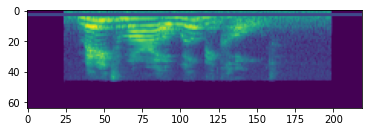

torch.Size([1, 64, 219])


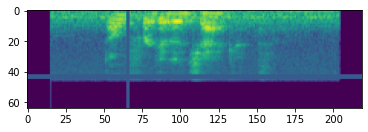

torch.Size([1, 64, 219])


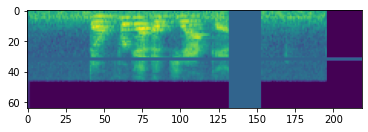

torch.Size([1, 64, 219])


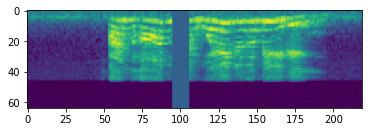

torch.Size([1, 64, 219])


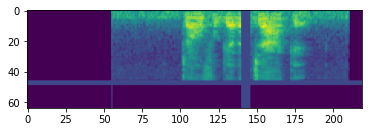

In [ ]:
for i in range(5):
  aud = (torch.tensor(Crema_df.loc[i, 'Signal'].reshape((1, -1))), req_sr)
  aud = AudioUtil.pad_trunc(aud, avg_duration)
  shift_aud = AudioUtil.time_shift(aud, 0.4)
  sgram = AudioUtil.mel_spectrogram(aud)
  aug_sgram = AudioUtil.spectro_augment(sgram)
  plt.imshow(aug_sgram[0,:,:])
  print(aug_sgram.shape)
  plt.show()

### Dataset and DataLoader

In [ ]:
from torch.utils.data import DataLoader, Dataset

class AudioDS(Dataset):
  def __init__(self, df, req_sr, req_time_ms):
    self.df = df
    self.duration = req_time_ms
    self.sr = req_sr
    self.shift_pct = 0.4
            
  def __len__(self):
    return len(self.df)    
    
  def __getitem__(self, idx):

    # audio_path = self.df.loc[idx, 'Path']
    aud = (torch.tensor(Crema_df.loc[idx, 'Signal'].reshape((1, -1))), req_sr)
    class_id = self.df.loc[idx, 'Label']

    # Read the audio from the disk
    # aud = AudioUtil.loadaudio(audio_path)
    # Resample to a new sampling rate
    aud = AudioUtil.resample(aud, self.sr)
    # Trancation or padding to have a fixed length
    aud = AudioUtil.pad_trunc(aud, self.duration)
    # Randomly Shift the signal in time
    shift_aud = AudioUtil.time_shift(aud, self.shift_pct)
    # Create the mel spectogram
    sgram = AudioUtil.mel_spectrogram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    # Create the augmented mel spectogram
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return aug_sgram, class_id

In [ ]:
from torch.utils.data import random_split

my_dataset = AudioDS(Crema_df, req_sr, avg_duration)

# Random split of 65:5:30 between training and validation and testing
num_items = len(my_dataset)
num_train = round(num_items * 0.65)
num_val = round(num_items * 0.05)
num_test = num_items - num_train - num_val

train_ds, val_ds, test_ds = random_split(my_dataset, [num_train, num_val, num_test])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

### The Models

###### Model 1

In [ ]:
import torch.nn.functional as F
from torch import nn
from torch.nn import init

class AudioClassifierModel1 (nn.Module):
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Third Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Fourth Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=6)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# Create the model and put it on the GPU if available
myModel = AudioClassifierModel1()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cuda', index=0)

##### Model 2

In [ ]:
import torch.nn.functional as F
from torch import nn
from torch.nn import init

class AudioClassifierModel2 (nn.Module):
    def __init__(self):
        super().__init__()
        conv_layers = []

        # Convolution Block 1 | input size = 64x219
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Convolution Block 2 | input size = 33x110
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Convolution Block 3 | input size = 17x56
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Convolution Block 4 | input size = 17x56
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Convolution Block 5 | input size = 9x29
        self.conv5 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu5 = nn.ReLU()
        self.bn5 = nn.BatchNorm2d(128)
        init.kaiming_normal_(self.conv5.weight, a=0.1)
        self.conv5.bias.data.zero_()
        conv_layers += [self.conv5, self.relu5, self.bn5]

        # Convolution Block 6 | input size = 5x15
        self.conv6 = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu6 = nn.ReLU()
        self.bn6 = nn.BatchNorm2d(256)
        init.kaiming_normal_(self.conv6.weight, a=0.1)
        self.conv6.bias.data.zero_()
        conv_layers += [self.conv6, self.relu6, self.bn6]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.fc1 = nn.Linear(in_features=256, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=6)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        # Final output
        return x

# Create the model and put it on the GPU if available
myModel = AudioClassifierModel2()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cpu')

### Training

In [ ]:
def inference (model, dataloader):
  all_preds = torch.tensor([])
  all_labels = torch.tensor([])

  # Disable gradient updates
  with torch.no_grad():
    for data in dataloader:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_std = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_std

      # Get predictions
      predictions = model(inputs)

      all_preds = torch.cat((all_preds, predictions), dim=0)
      all_labels = torch.cat((all_labels, labels), dim=0)

  _, prediction = torch.max(all_preds, 1)

  return all_labels, prediction

In [ ]:
train_accuracy = []
val_accuracy = []
epoch = 0

def training(model, train_dl, val_dl, num_epochs):
  global epoch
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  # Repeat for each epoch
  for _ in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]
    
    # collect stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction / total_prediction

    y, y_pred = inference(model, val_dl)
    correct_prediction = (y == y_pred).sum().item()
    val_acc = correct_prediction / len(y_pred)

    train_accuracy.append(acc)
    val_accuracy.append(val_acc)

    epoch += 1
    print(f'Epoch {epoch:3d} => Loss: {avg_loss:.3f} | Training Accuracy : {acc:.3f} | Validation Accuracy : {val_acc:.3f}')

  print('Finished Training')
  
num_epochs=30
training(myModel, train_dl, val_dl, num_epochs)

Epoch   1 => Loss: 1.634 | Training Accuracy : 0.308 | Validation Accuracy : 0.363
Epoch   2 => Loss: 1.480 | Training Accuracy : 0.384 | Validation Accuracy : 0.422
Epoch   3 => Loss: 1.452 | Training Accuracy : 0.407 | Validation Accuracy : 0.430
Epoch   4 => Loss: 1.421 | Training Accuracy : 0.422 | Validation Accuracy : 0.417
Epoch   5 => Loss: 1.399 | Training Accuracy : 0.435 | Validation Accuracy : 0.425
Epoch   6 => Loss: 1.383 | Training Accuracy : 0.441 | Validation Accuracy : 0.430
Epoch   7 => Loss: 1.355 | Training Accuracy : 0.461 | Validation Accuracy : 0.452
Epoch   8 => Loss: 1.336 | Training Accuracy : 0.469 | Validation Accuracy : 0.470
Epoch   9 => Loss: 1.320 | Training Accuracy : 0.472 | Validation Accuracy : 0.435
Epoch  10 => Loss: 1.294 | Training Accuracy : 0.484 | Validation Accuracy : 0.478
Epoch  11 => Loss: 1.278 | Training Accuracy : 0.499 | Validation Accuracy : 0.487
Epoch  12 => Loss: 1.256 | Training Accuracy : 0.501 | Validation Accuracy : 0.470
Epoc

In [ ]:
num_epochs=20
training(myModel, train_dl, val_dl, num_epochs)

Epoch  91 => Loss: 0.645 | Training Accuracy : 0.762 | Validation Accuracy : 0.570
Epoch  92 => Loss: 0.670 | Training Accuracy : 0.745 | Validation Accuracy : 0.567
Epoch  93 => Loss: 0.673 | Training Accuracy : 0.744 | Validation Accuracy : 0.543
Epoch  94 => Loss: 0.717 | Training Accuracy : 0.732 | Validation Accuracy : 0.551
Epoch  95 => Loss: 0.719 | Training Accuracy : 0.730 | Validation Accuracy : 0.562
Epoch  96 => Loss: 0.760 | Training Accuracy : 0.710 | Validation Accuracy : 0.570
Epoch  97 => Loss: 0.778 | Training Accuracy : 0.706 | Validation Accuracy : 0.540
Epoch  98 => Loss: 0.763 | Training Accuracy : 0.709 | Validation Accuracy : 0.578
Epoch  99 => Loss: 0.738 | Training Accuracy : 0.716 | Validation Accuracy : 0.583
Epoch 100 => Loss: 0.744 | Training Accuracy : 0.713 | Validation Accuracy : 0.581
Epoch 101 => Loss: 0.714 | Training Accuracy : 0.722 | Validation Accuracy : 0.581
Epoch 102 => Loss: 0.717 | Training Accuracy : 0.724 | Validation Accuracy : 0.543
Epoc

In [ ]:
# Save the model
# torch.save(myModel, '/content/drive/MyDrive/Deep Learning/model_trainAcc75_valAcc59.pt')
# Load the model
# myModel2 = torch.load('/content/drive/MyDrive/Deep Learning/model_trainAcc69_valAcc60.pt')
# myModel2.eval()

### Testing

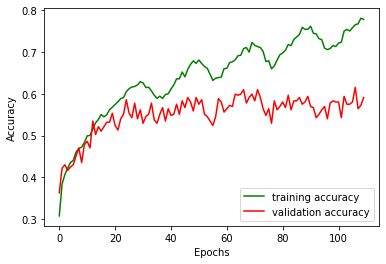

In [ ]:
plt.plot(train_accuracy, 'g-', label='training accuracy')
plt.plot(val_accuracy, 'r-', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
# plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

y, y_pred = inference(myModel, test_dl)
# Accuracy
test_acc = accuracy_score(y, y_pred)
# F1 Score
f1score = f1_score(y, y_pred, average='macro')
# Confusion Matrix
conf_matrix = pd.DataFrame(confusion_matrix(y, y_pred), index=labels, columns=labels)

print(f'Accuracy Score\t: {test_acc:.3f}')
print(f'F1 Score\t: {f1score:.3f}')
print("Confusion Matrix:")
print(conf_matrix)

Accuracy Score	: 0.591
F1 Score	: 0.589
Confusion Matrix:
         sad  angry  disgust  fear  happy  neutral
sad      224      2       51    53      9       49
angry      2    304       28    21     36       10
disgust   54     22      200    34     42       21
fear      82     12       27   182     43       16
happy     16     44       32    44    208       30
neutral   41      5       28    20     40      201
